In [1]:
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [2]:
# Load data
data = pd.read_csv("ts2024.csv")

# Convert "Date" and "Hour" into datetime
data["DateTime"] = pd.to_datetime(data["Date"]) + pd.to_timedelta(data["Hour"], unit="h")

# Sort by datetime (just in case)
data.sort_index(inplace=True)

# Set index
data.set_index("DateTime", inplace=True)

data = data.drop(columns=['Date'])

# Add the new features
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek
data["Quarter"] = data.index.quarter

df = data[data['X'].notna()]
df_to_predict = data[data['X'].isna()].drop(columns=['X'])

## Data Exploration

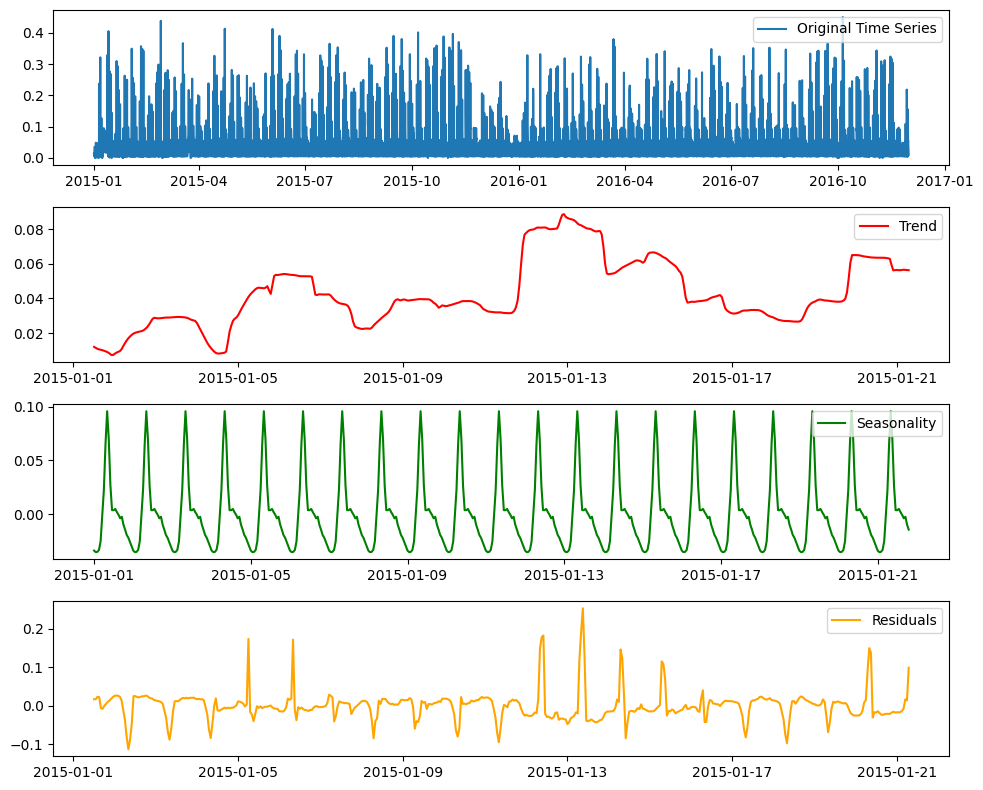

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposition = seasonal_decompose(df["X"][:500], model="additive", period=24)  # Adjust period based on your data

# Plot decomposition
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df["X"], label="Original Time Series")
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label="Trend", color='red')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonality", color='green')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label="Residuals", color='orange')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

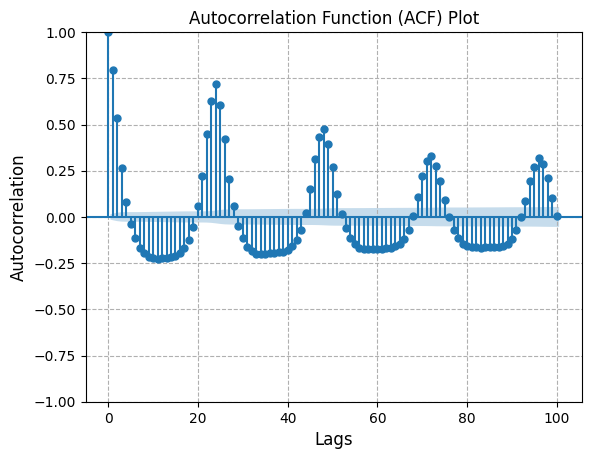

In [4]:
# Create a larger figure for better visualization
plt.figure(figsize=(14, 7))

# Plot the Autocorrelation Function (ACF) with 100 lags
plot_acf(df["X"], lags=100, title="Autocorrelation Function (ACF) Plot")

# Add labels and grid for better readability
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.grid(True, linestyle="--")

# Display the plot
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df["X"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:", result[4])

# If p-value < 0.05, series is stationary, else we need differencing

ADF Statistic: -15.711048192077207
p-value: 1.359370866222885e-28
Critical Values: {'1%': -3.4307403492768214, '5%': -2.8617125188208488, '10%': -2.5668618273740047}


In [6]:
# Split data for train and test dataset     
pred_number = 720
train = df.iloc[:-pred_number]
test = df.iloc[-pred_number:]

# Print shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (16080, 7)
Test shape: (720, 7)


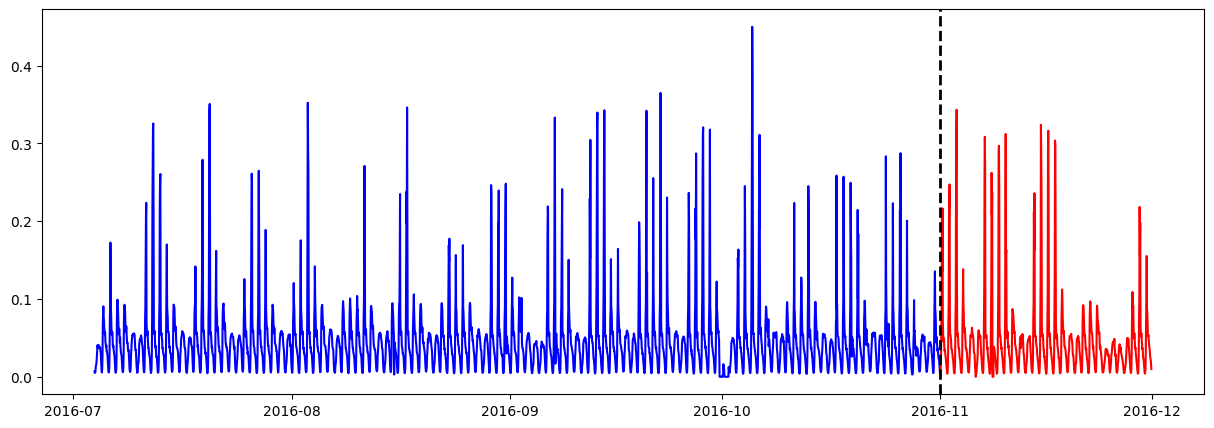

In [7]:
# Get the split date (first date of the test set)
split_date = test.index[0]

# Plot with a visible split
plt.figure(figsize=(15, 5))
plt.plot(train.index[-4 * pred_number:], train["X"][-4 * pred_number:], label="Train Data", color="blue")
plt.plot(test.index, test["X"], label="Test Data", color="red")
plt.axvline(x=split_date, color="black", linestyle="--", linewidth=2, label="Train-Test Split")

### ARIMA

In [11]:
# Find optimal SARIMA parameters
auto_sarima = auto_arima(train["X"][-1000:],
                         seasonal=True,
                         m=24,  # Seasonal period
                         stepwise=True,
                         trace=True)

# Print best order
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-4237.354, Time=5.40 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-3100.437, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-4221.431, Time=3.39 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-3947.439, Time=3.47 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-2507.093, Time=0.81 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-4171.876, Time=5.47 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-4223.327, Time=3.09 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-4253.504, Time=13.28 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-4226.040, Time=10.93 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=12.82 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=inf, Time=12.39 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=-4256.395, Time=12.65 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=-4253.825, Time=2.76 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-4228.277, Time=9.65 sec
 ARIMA(1,0,2

MemoryError: Unable to allocate 4.77 MiB for an array with shape (25, 25, 1001) and data type float64

In [13]:
# Get optimal parameters
p, d, q = (1, 0, 2)
P, D, Q = (2, 0, 1)

# Fit SARIMA model
sarima_model = SARIMAX(train["X"],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, 24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()

# Print model summary
print(sarima_fit.summary())

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    X   No. Observations:                16080
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 24)   Log Likelihood               37551.243
Date:                              Sun, 16 Feb 2025   AIC                         -75088.486
Time:                                      16:15:27   BIC                         -75034.710
Sample:                                           0   HQIC                        -75070.702
                                            - 16080                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5351      0.010     53.972      0.000       0.516       0.555
ma.L1          0.20

In [69]:
def evaluation(forecast, name_forecast):
    # Plot results
    plt.figure(figsize=(12, 5))
    plt.plot(test.index, test["X"], label="Actual", color="blue")
    plt.plot(test.index, forecast, label=name_forecast, color="red")
    plt.xlabel("DateTime")
    plt.ylabel("X Values")
    plt.title(f"{name_forecast} vs Actual")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Compute Metrics
    mae = mean_absolute_error(test["X"], forecast)
    mse = mean_squared_error(test["X"], forecast)

    # Print Results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


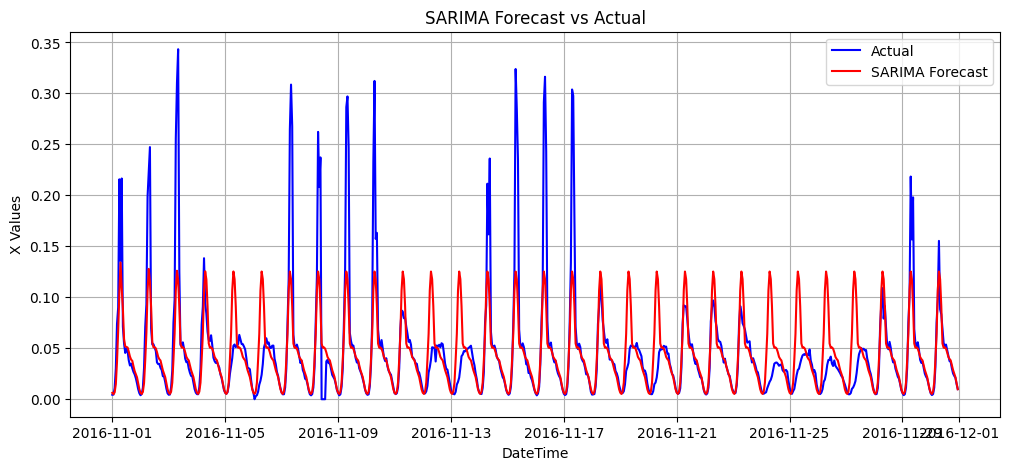

Mean Absolute Error (MAE): 0.01770718844752115
Mean Squared Error (MSE): 0.0015292358513085752


In [70]:
# Forecast
forecast_sarima = sarima_fit.forecast(steps=pred_number)

evaluation(forecast_sarima, "SARIMA Forecast")

### UMC

In [16]:
# Fit Unobserved Components Model (UCM)
ucm_model = UnobservedComponents(
    train["X"],
    level="local level",
    seasonal=24,  # Daily seasonality (24-hour pattern)
    exog=train[["Hour", "Year", "Month", "Day", "DayOfWeek", "Quarter"]]
)

ucm_fit = ucm_model.fit()

# Print model summary
print(ucm_fit.summary())

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16080
Model:                           local level   Log Likelihood               35614.030
                   + stochastic seasonal(24)   AIC                         -71210.060
Date:                       Sun, 16 Feb 2025   BIC                         -71140.906
Time:                               16:16:13   HQIC                        -71187.192
Sample:                                    0                                         
                                     - 16080                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.737e-09   2.13e-06      0.001      0

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


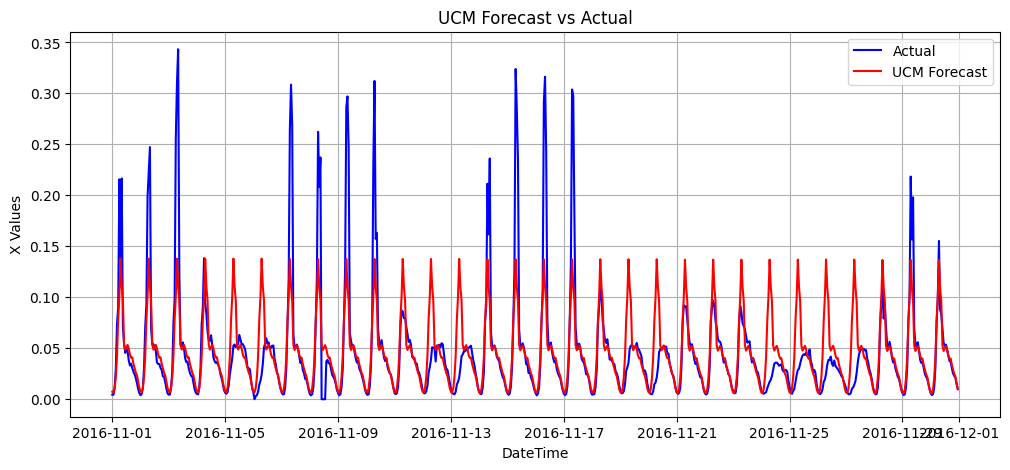

Mean Absolute Error (MAE): 0.018074291897627104
Mean Squared Error (MSE): 0.0015342301006283218


In [71]:
# Forecast future values
forecast_ucm = ucm_fit.forecast(steps=pred_number, exog=test[["Hour", "Year", "Month", "Day", "DayOfWeek", "Quarter"]])

evaluation(forecast_ucm, "UCM Forecast")

### 

### XGBoost

In [19]:
X_train = train.drop(columns=['X'])
y_train = train['X']

X_test = test.drop(columns=['X'])
y_test = test['X']

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Define hyperparameter search space
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size for updates
    'max_depth': [3, 5, 7, 10],  # Depth of trees
    'subsample': [0.5, 0.7, 0.9, 1.0],  # % of samples per round
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],  # % of features per tree
    'gamma': [0, 0.1, 0.5, 1, 5, 10]  # Min loss reduction for a split
}

xgb_model = xgb.XGBRegressor(objective="reg:absoluteerror",  # Optimizes MAE
                             eval_metric="mae")  # Sets MAE as the evaluation metric)

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform random search
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid,
    n_iter=30, scoring='neg_mean_absolute_error',
    cv=tscv, verbose=2, random_state=42, n_jobs=-1
)

# Fit model with time series generator input
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}


In [21]:
best_xgb_model = random_search.best_estimator_  # Reuse the trained model
best_xgb_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_test, y_test)],
                   verbose=True)

[0]	validation_0-mae:0.02402	validation_1-mae:0.02648
[1]	validation_0-mae:0.02089	validation_1-mae:0.02377
[2]	validation_0-mae:0.01817	validation_1-mae:0.02130
[3]	validation_0-mae:0.01602	validation_1-mae:0.01933
[4]	validation_0-mae:0.01436	validation_1-mae:0.01774
[5]	validation_0-mae:0.01307	validation_1-mae:0.01661
[6]	validation_0-mae:0.01195	validation_1-mae:0.01558
[7]	validation_0-mae:0.01112	validation_1-mae:0.01482
[8]	validation_0-mae:0.01037	validation_1-mae:0.01408
[9]	validation_0-mae:0.01010	validation_1-mae:0.01385
[10]	validation_0-mae:0.00987	validation_1-mae:0.01365
[11]	validation_0-mae:0.00970	validation_1-mae:0.01348
[12]	validation_0-mae:0.00957	validation_1-mae:0.01336
[13]	validation_0-mae:0.00923	validation_1-mae:0.01306
[14]	validation_0-mae:0.00916	validation_1-mae:0.01299
[15]	validation_0-mae:0.00910	validation_1-mae:0.01292
[16]	validation_0-mae:0.00906	validation_1-mae:0.01288
[17]	validation_0-mae:0.00895	validation_1-mae:0.01285
[18]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

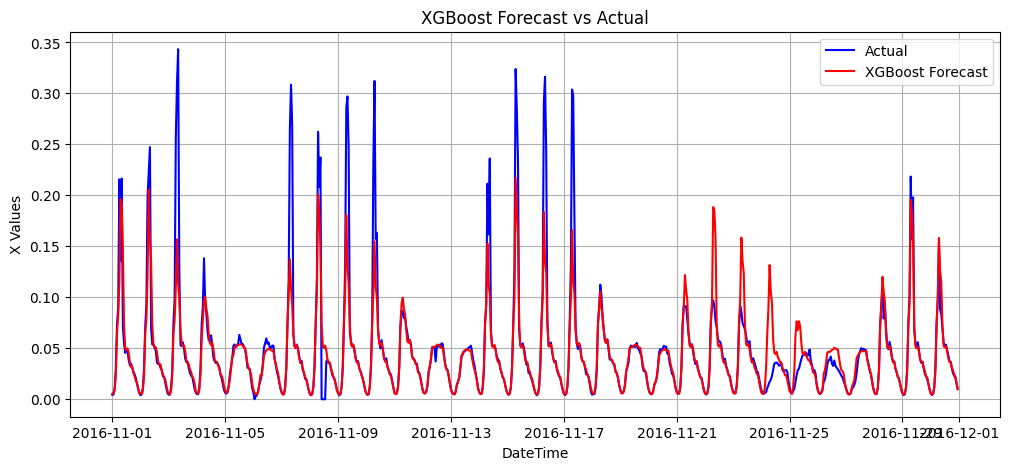

Mean Absolute Error (MAE): 0.010078958912063389
Mean Squared Error (MSE): 0.000869482561041418


In [72]:
# Make predictions on test set
forecast_xgb = best_xgb_model.predict(X_test)

evaluation(forecast_xgb, "XGBoost Forecast")

### Future Predictions

In [29]:
forecast_horizon = 744
X_train = df.drop(columns=['X'])
y_train = df['X']

### SARIMA

In [30]:
# Fit SARIMA model
sarima_model = SARIMAX(y_train,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, 24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()

# Print model summary
print(sarima_fit.summary())

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                    X   No. Observations:                16800
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood               39307.553
Date:                              Sun, 16 Feb 2025   AIC                         -78601.106
Time:                                      16:20:11   BIC                         -78547.024
Sample:                                           0   HQIC                        -78583.259
                                            - 16800                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3602      0.085      4.257      0.000       0.194       0.526
ar.L2          0.07

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


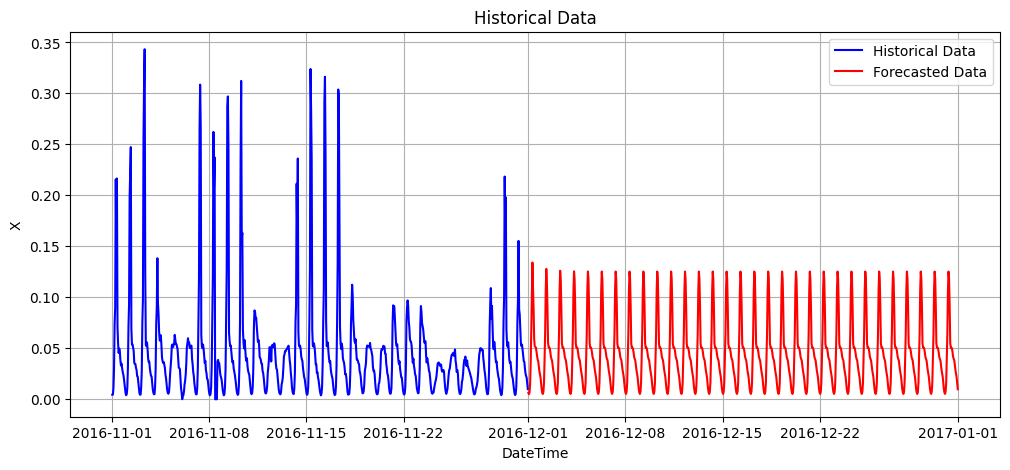

In [31]:
pred_sarima = sarima_fit.forecast(steps=forecast_horizon)

# Plot the historical data on the left side
plt.figure(figsize=(12, 5))
plt.plot(df[-pred_number:].index, df[-pred_number:]["X"], label="Historical Data", color="blue")
plt.plot(df_to_predict.index, pred_sarima, label="Forecasted Data", color="red")
plt.xlabel('DateTime')
plt.ylabel('X')
plt.title('Historical Data')
plt.legend(loc="best")
plt.grid(True)

In [40]:
pred_sarima

16800    0.006239
16801    0.004939
16802    0.006723
16803    0.014865
16804    0.036739
           ...   
17539    0.028635
17540    0.025175
17541    0.021683
17542    0.015660
17543    0.009807
Name: predicted_mean, Length: 744, dtype: float64

### UCM

In [32]:
# Split the data for training and forecasting
train_data = data.iloc[:-forecast_horizon]  # Historical data up until the forecast horizon
exog_train = train_data[["Hour", "Year", "Month", "Day", "DayOfWeek", "Quarter"]]  # Exogenous variables for training

# Fit Unobserved Components Model (UCM)
ucm_model = UnobservedComponents(
    df["X"],
    level="local level",
    seasonal=24,  # Daily seasonality (24-hour pattern)
    exog=exog_train
)

ucm_fit = ucm_model.fit()

# Print model summary
print(ucm_fit.summary())

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16800
Model:                           local level   Log Likelihood               37112.835
                   + stochastic seasonal(24)   AIC                         -74207.671
Date:                       Sun, 16 Feb 2025   BIC                         -74138.122
Time:                               16:20:46   HQIC                        -74184.721
Sample:                                    0                                         
                                     - 16800                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.666e-10   2.12e-06   7.84e-05      1

C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eljas\PycharmProjects\Time Series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


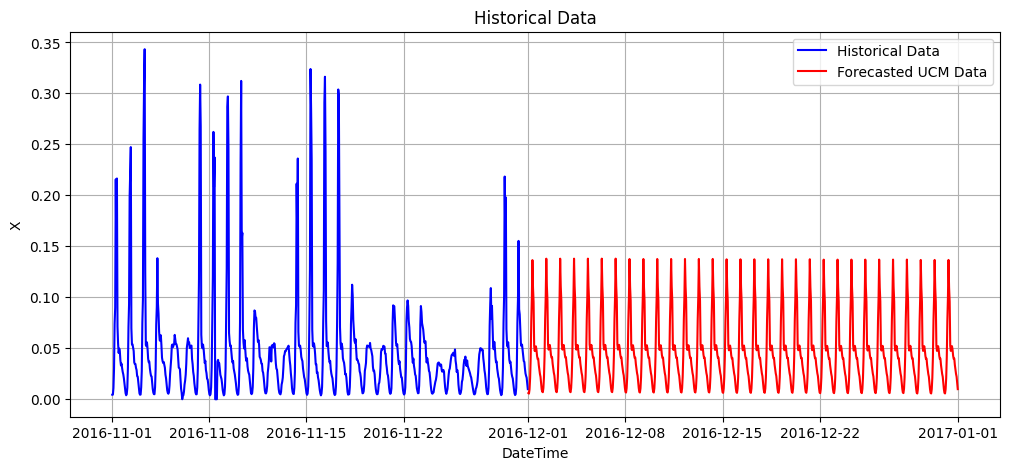

In [33]:
pred_ucm = ucm_fit.forecast(steps=forecast_horizon, exog=exog_train.iloc[-forecast_horizon:])

# Plot the historical data on the left side
plt.figure(figsize=(12, 5))
plt.plot(df[-pred_number:].index, df[-pred_number:]["X"], label="Historical Data", color="blue")
plt.plot(df_to_predict.index, pred_ucm, label="Forecasted UCM Data", color="red")
plt.xlabel('DateTime')
plt.ylabel('X')
plt.title('Historical Data')
plt.legend(loc="best")
plt.grid(True)

In [41]:
pred_ucm

16800    0.006052
16801    0.005509
16802    0.009676
16803    0.020736
16804    0.041013
           ...   
17539    0.029276
17540    0.024848
17541    0.022060
17542    0.016210
17543    0.009900
Name: predicted_mean, Length: 744, dtype: float64

### XGBoost

In [34]:
best_xgb_model = random_search.best_estimator_  # Reuse the trained model
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

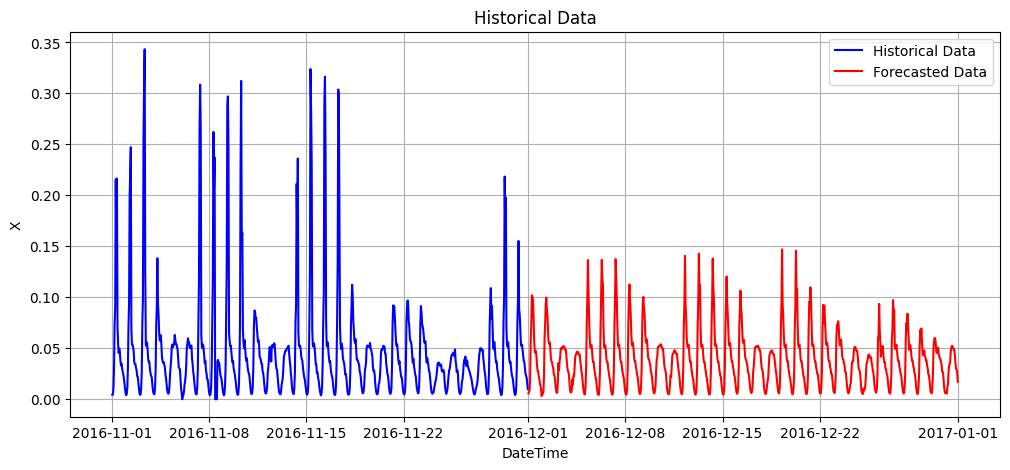

In [35]:
pred_xgb = best_xgb_model.predict(df_to_predict)

# Plot the historical data on the left side
plt.figure(figsize=(12, 5))
plt.plot(df[-pred_number:].index, df[-pred_number:]["X"], label="Historical Data", color="blue")
plt.plot(df_to_predict.index, pred_xgb, label="Forecasted Data", color="red")
plt.xlabel('DateTime')
plt.ylabel('X')
plt.title('Historical Data')
plt.legend(loc="best")
plt.grid(True)

In [63]:
pred_xgb_series = pd.Series(pred_xgb, name="ML")

# Define new index range
new_index = range(16800, 17544)  # 17543 is inclusive, so we go up to 17544

# Assign the new index
pred_xgb_series.index = new_index
pred_xgb_series

16800    0.005682
16801    0.006649
16802    0.008737
16803    0.019357
16804    0.058273
           ...   
17539    0.035385
17540    0.029828
17541    0.029391
17542    0.025950
17543    0.017095
Name: ML, Length: 744, dtype: float32

In [64]:
# Load data
data = pd.read_csv("ts2024.csv", usecols=["DateTime", "X"])
data = data[data["X"].isna()]
data

,DateTime,X
16800,2016-12-01,NaN
16801,2016-12-01 01:00:00,NaN
16802,2016-12-01 02:00:00,NaN
16803,2016-12-01 03:00:00,NaN
16804,2016-12-01 04:00:00,NaN
...,...,...
17539,2016-12-31 19:00:00,NaN
17540,2016-12-31 20:00:00,NaN
17541,2016-12-31 21:00:00,NaN
17542,2016-12-31 22:00:00,NaN


In [68]:
# Assuming pred_sarima, pred_ucm, and pred_xgb are numpy arrays:
# Convert them to pandas Series
pred_sarima_series = pd.Series(pred_sarima, name="ARIMA")
pred_ucm_series = pd.Series(pred_ucm, name="UCM")

# Concatenate them into a DataFrame
predictions = pd.concat([data['DateTime'], pred_sarima_series, pred_ucm_series, pred_xgb_series], axis=1)

# Display the resulting DataFrame
# Set index
predictions.set_index("DateTime", inplace=True)
predictions.to_csv("909837_20250216.csv")
predictions

,ARIMA,UCM,ML
DateTime,,,
2016-12-01,0.006239,0.006052,0.005682
2016-12-01 01:00:00,0.004939,0.005509,0.006649
2016-12-01 02:00:00,0.006723,0.009676,0.008737
2016-12-01 03:00:00,0.014865,0.020736,0.019357
2016-12-01 04:00:00,0.036739,0.041013,0.058273
...,...,...,...
2016-12-31 19:00:00,0.028635,0.029276,0.035385
2016-12-31 20:00:00,0.025175,0.024848,0.029828
2016-12-31 21:00:00,0.021683,0.022060,0.029391
